In [47]:
import pandas as pd
import itertools as itt
import ppinetsim
import networkx as nx
from os.path import join
import matplotlib.pyplot as plt
import json
import itertools as itt
import seaborn as sns
from scipy.stats import wasserstein_distance
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def to_string(x):
    return ''.join(str(x).split('.'))

def load_results(test_method, acceptance_threshold, false_positive_rate, false_negative_rate):
    infix = f'accTh{to_string(acceptance_threshold)}_FPR{to_string(false_positive_rate)}_FNR{to_string(false_negative_rate)}'
    directory = f'output_results/{test_method}/{infix}'
    posteriors = pd.read_csv(f'{directory}/likelihood_{test_method}_{infix}.csv')
    with open(f'{directory}/all_results_{test_method}_{infix}.json') as fp:
        all_results = json.load(fp)
    return posteriors, all_results

In [3]:
def deltas_sods(test_method, acceptance_threshold, fprs=None, fnrs=None, pivot=True):
    if fprs is None:
        fprs = [0.0,0.003125,0.00625,0.0125,0.025,0.05,0.1,0.2,0.4]
    if fnrs is None:
        fnrs = [0.0,0.1,0.2,0.3,0.4]
    data = {'FPR': [], 'FNR': [], 'delta_sod': []}
    for fpr, fnr in itt.product(fprs, fnrs):
        _, all_results = load_results(test_method, acceptance_threshold, fpr, fnr)
        sod_ba = 0.0
        sod_er = 0.0
        for dist, generator, _ in all_results:
            if generator == 'barabasi-albert':
                sod_ba += dist
            else:
                sod_er += dist
        data['delta_sod'].append((sod_ba - sod_er) / sod_er)
        data['FPR'].append(fpr)
        data['FNR'].append(fnr)
    deltas = pd.DataFrame(data=data)
    if pivot:
        return deltas.pivot('FPR', 'FNR', 'delta_sod')
    return deltas

In [21]:
def get_parameters(test_method, generator):
    if test_method == 'AP-MS':
        parameters = ppinetsim.Parameters('parameter_settings/all_param_combinations/AP-MS/params_AP-MS_accTh00_FPR00_FNR00.json')
    else:
        parameters = ppinetsim.Parameters('parameter_settings/all_param_combinations/Y2H/params_Y2H_accTh00_FPR00_FNR00.json')
    parameters.generator = generator
    return parameters

In [38]:
def construct_observed_network(parameters):
    edge_list = []
    for sampled_study in parameters.sampled_studies:
        filename = join('ppinetsim', 'data', parameters.test_method, f'{sampled_study}.csv')
        adj_sampled_study = pd.read_csv(filename, index_col=0)
        for edge in itt.product(adj_sampled_study.index, adj_sampled_study.columns):
            if adj_sampled_study.loc[edge]:
                edge_list.append(edge)
    observed_network = nx.Graph()
    observed_network.add_edges_from(edge_list)
    return nx.to_numpy_array(observed_network, dtype=bool)

In [29]:
params_apms_er = get_parameters('AP-MS', 'erdos-renyi')
params_apms_ba = get_parameters('AP-MS', 'barabasi-albert')
params_y2h_er = get_parameters('Y2H', 'erdos-renyi')
params_y2h_ba = get_parameters('Y2H', 'barabasi-albert')

In [39]:
adj_observed_apms = construct_observed_network(params_apms_er)

159764


In [120]:
pd.DataFrame(data=adj_observed_apms).to_csv('adj_observed_AP-MS.csv')

In [ ]:
adj_observed_apms = construct_observed_network(params_apms_er)

In [41]:
degree_dist_observed_apms = ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_observed_apms))

In [42]:
degree_dist_ground_truth_apms = {'erdos-renyi': [], 'barabasi-albert': []}
for _ in range(50):
    adj_ground_truth_er, _, _, _ = ppinetsim.initialize_matrices(params_apms_er)
    degree_dist_ground_truth_apms['erdos-renyi'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_er)))
    adj_ground_truth_ba, _, _, _ = ppinetsim.initialize_matrices(params_apms_ba)
    degree_dist_ground_truth_apms['barabasi-albert'].append(ppinetsim.degrees_to_distribution(ppinetsim.node_degrees(adj_ground_truth_ba)))

In [43]:
dists_apms_er = [wasserstein_distance(degree_dist_observed_apms[0, ], degree_dist_ground_truth[0, ],
                                      degree_dist_observed_apms[1, ], degree_dist_ground_truth[1, ])
                 for degree_dist_ground_truth in degree_dist_ground_truth_apms['erdos-renyi']]

In [45]:
dists_apms_ba = [wasserstein_distance(degree_dist_observed_apms[0, ], degree_dist_ground_truth[0, ],
                                      degree_dist_observed_apms[1, ], degree_dist_ground_truth[1, ])
                 for degree_dist_ground_truth in degree_dist_ground_truth_apms['barabasi-albert']]

In [107]:
distances = pd.DataFrame(data={'Ground truth': ['Ground truth\nPL-distributed' for _ in range(50)] + ['Ground truth\nbinomially distributed' for _ in range(50)],
                               'EMD': dists_apms_ba + dists_apms_er})

In [78]:
distances

,Ground truth,EMD
0,PL-distributed,9.407553
1,PL-distributed,9.386173
2,PL-distributed,9.396863
3,PL-distributed,9.371264
4,PL-distributed,9.407835
...,...,...
95,Binomially distributed,17.602926
96,Binomially distributed,17.600394
97,Binomially distributed,17.623180
98,Binomially distributed,17.596174


<AxesSubplot:xlabel='Count', ylabel='EMD'>

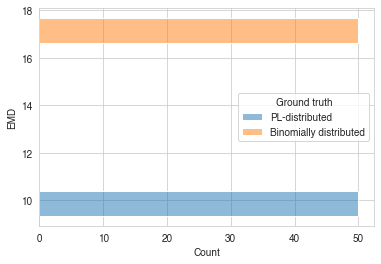

In [94]:
sns.histplot(data=distances, y='EMD', hue='Ground truth', legend={'loc': 'upper left'})

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


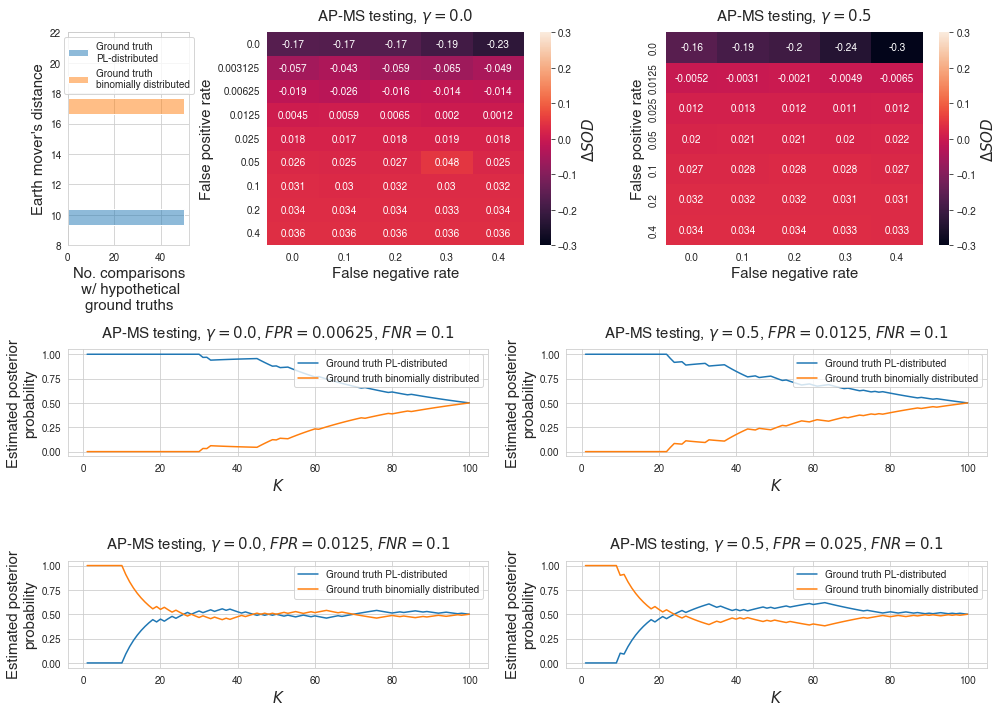

In [117]:
fig, axes = plt.subplot_mosaic(mosaic=[
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['G','G','A','A','A','A','B','B','B','B'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['C','C','C','C','C','D','D','D','D','D'],
    ['E','E','E','E','E','F','F','F','F','F'],
    ['E','E','E','E','E','F','F','F','F','F']],figsize=(14,10))
sns.histplot(data=distances, y='EMD', hue='Ground truth', ax=axes['G'])
axes['G'].set_ylabel("Earth mover's distance", fontsize=15)
axes['G'].set_xlabel("No. comparisons\n w/ hypothetical\nground truths", fontsize=15)
axes['G'].set_ylim(8,22)
sns.move_legend(axes['G'], "upper center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=True)
sns.heatmap(deltas_sods('AP-MS', 0.0),annot=True,ax=axes['A'],vmin=-.3,vmax=.3)
sns.heatmap(deltas_sods('AP-MS', 0.5, fprs=[0.0,0.0125,0.025,0.05,0.1,0.2,0.4]),annot=True,ax=axes['B'],vmin=-.3,vmax=.3)
for label, gamma in [('A',0.0), ('B', 0.5)]:
    axes[label].set_title(r'AP-MS testing, $\gamma={}$'.format(gamma),pad=12,fontsize=15)
    axes[label].set_xlabel('False negative rate', fontsize=15)
    axes[label].set_ylabel('False positive rate', fontsize=15)
    colorbar = axes[label].collections[0].colorbar
    colorbar.set_label(r'$\Delta\mathit{SOD}$',fontsize=15)
for label, gamma, fpr in [('C', 0.0, 0.00625), ('D', 0.5, 0.0125), ('E', 0.0, 0.0125), ('F', 0.5, 0.025)]:
    posteriors, _ = load_results('AP-MS', acceptance_threshold=gamma,
                                 false_positive_rate=fpr, false_negative_rate=0.1)
    ppinetsim.plot_posteriors(posteriors, ax=axes[label], parameters={'acceptance_threshold': gamma,
                                                      'false_positive_rate': fpr,
                                                      'false_negative_rate': 0.1, 'test_method': 'AP-MS'})
    axes[label].set_title(r'AP-MS testing, $\gamma={}$, $FPR={}$, $FNR=0.1$'.format(gamma, fpr),pad=12,fontsize=15)
    axes[label].set_ylabel('Estimated posterior\nprobability',fontsize=15)
    axes[label].set_xlabel(r'$K$', fontsize=15)
    handles, labels = axes[label].get_legend_handles_labels()
    axes[label].legend(handles=handles[0:], labels=labels[0:],loc='upper right')
fig.tight_layout()
fig.savefig('simulation_AP-MS.pdf')

[Text(0.5, 1.0, 'Y2H testing, $\\gamma=0.0$')]

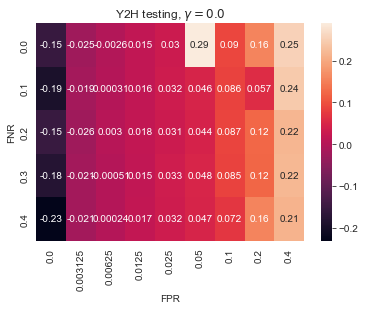

In [5]:
deltas_Y2H = deltas_sods('Y2H', 0.0)
sns.heatmap(deltas_Y2H.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'Y2H testing, $\gamma={}$'.format(0.0))

[Text(0.5, 1.0, 'Y2H testing, $\\gamma=0.5$')]

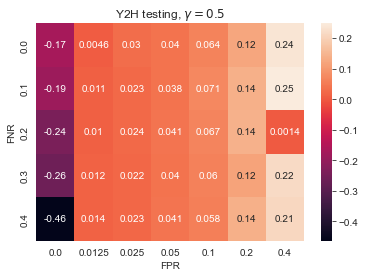

In [21]:
deltas_Y2H = deltas_sods('Y2H', 0.5)
sns.heatmap(deltas_Y2H.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'Y2H testing, $\gamma={}$'.format(0.5))

[Text(0.5, 1.0, 'AP-MS testing, $\\gamma=0.0$')]

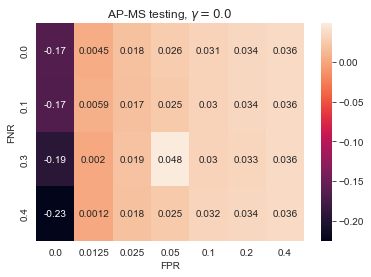

In [25]:
deltas_AP_MS = deltas_sods('AP-MS', 0.0)
sns.heatmap(deltas_AP_MS.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'AP-MS testing, $\gamma={}$'.format(0.0))

[Text(0.5, 1.0, 'AP-MS testing, $\\gamma=0.5$')]

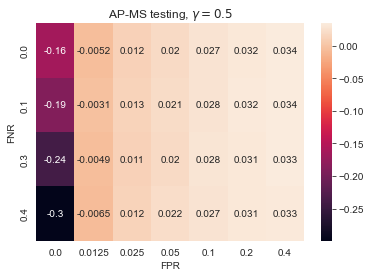

In [24]:
deltas_AP_MS = deltas_sods('AP-MS', 0.5)
sns.heatmap(deltas_AP_MS.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'AP-MS testing, $\gamma={}$'.format(0.5))

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.00625$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

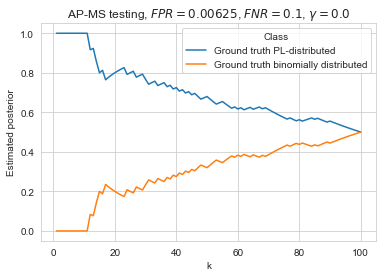

In [14]:
posteriors, all_results = load_results('Y2H', acceptance_threshold=0.0, false_positive_rate=0.003125, false_negative_rate=0.2)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.00625, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.0125$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

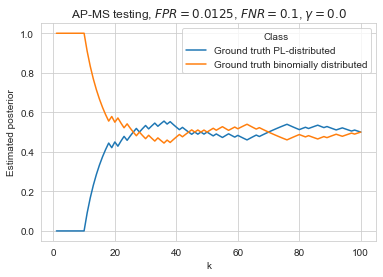

In [7]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.0125, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.0125, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

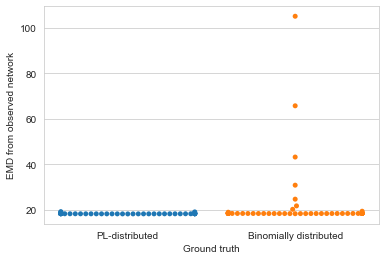

In [18]:
ppinetsim.plot_distances(all_results,kind='swarm')![](../../../../../var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/TemporaryItems/NSIRD_screencaptureui_VsBReD/Screenshot 2023-02-17 at 13.02.21.png)

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.0125$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

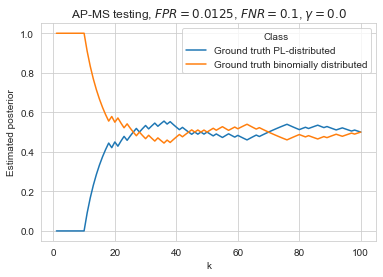

In [11]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.0125, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.0125, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

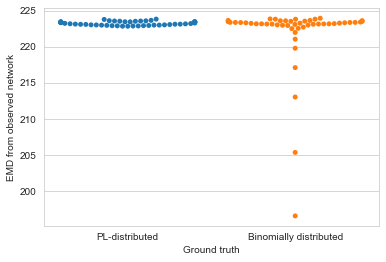

In [12]:
ppinetsim.plot_distances(all_results,kind='swarm')

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.1$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

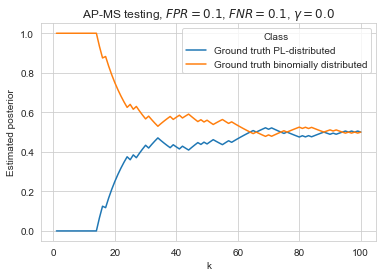

In [15]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.2, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.1, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

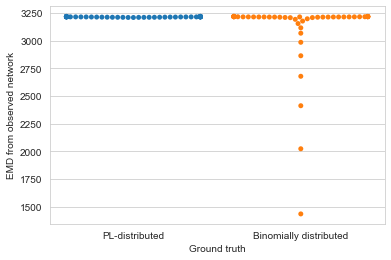

In [16]:
ppinetsim.plot_distances(all_results,kind='swarm')

[Text(0.5, 1.0, 'FPR=0.0, FNR=0.1, $\\gamma$=0.0')]

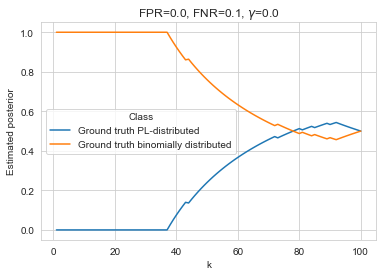

In [30]:
posteriors, _ = load_results('Y2H', acceptance_threshold=0.0, false_positive_rate=0.0, false_negative_rate=0.1)
posteriors.rename(columns={'Erdos-Renyi': 'Ground truth binomially distributed', 'Barabasi-Albert': 'Ground truth PL-distributed'}, inplace=True)
ppinetsim.plot_posteriors(posteriors, acceptance_threshold=0.0, false_positive_rate=0.0, false_negative_rate=0.1)